In [1]:
import os
import plaidml.keras
plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [2]:
import keras
import keras.backend as K

import glob
import os

import skimage.io
import imageio

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt



import gated_shape_cnn
import gated_shape_cnn.datasets.cityscapes
import gated_shape_cnn.datasets.cityscapes.dataset
from gated_shape_cnn.model import export_model, GSCNNInfer
from gated_shape_cnn.datasets.cityscapes.raw_dataset import CityScapesRaw
from gated_shape_cnn.training.train_and_evaluate import train_model
from gated_shape_cnn.datasets import cityscapes

import cityscapesscripts.evaluation.evalPixelLevelSemanticLabeling

### Summary of Gated-Shape CNN model

In [7]:
# check model summary
import gated_shape_cnn.model.model_definition
test = gated_shape_cnn.model.model_definition.GSCNN(19)
input = tf.keras.Input([None, None, 3], dtype=tf.uint8)
float_input = tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32))(input)
test(float_input, training=False)
test.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'do_return' is nonlocal and global (tmpijkqnh0z.py, line 19)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'do_return' is nonlocal and global (tmpijkqnh0z.py, line 19)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "gscnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_backbone (Mobile multiple                  2257984   
_________________________________________________________________
shape_stream (ShapeStream)   multiple                  39827     
_

#### Hyperparameters for model training

In [224]:
batch_size = 4
network_input_h = network_input_w = 224
max_crop_downsample = 0.2
colour_aug_factor = 0.2

### Define data directory path and augmentation parameters

In [225]:
data_dir_with_edge_maps = 'cityscape'
cityscapes_dataset_loader = gated_shape_cnn.datasets.cityscapes.dataset.CityScapes(
    batch_size,
    network_input_h,
    network_input_w,
    max_crop_downsample,
    colour_aug_factor,
    debug=False,
    data_dir=data_dir_with_edge_maps)

### Train the model

In [226]:
n_train_images = 2975
n_steps_in_epoch = n_train_images // batch_size
optimiser = tf.keras.optimizers.Adam()

# train the model
train_model(
    n_classes=cityscapes_dataset_loader.n_classes,
    train_data=cityscapes_dataset_loader.build_training_dataset(),
    val_data=cityscapes_dataset_loader.build_validation_dataset(),
    optimiser=optimiser,
    epochs=30,
    log_dir='./logs',
    model_dir='./logs/model',
    accum_iterations=4,
    loss_weights=(1., 1., 1., 1.)
)

Epoch 0
Training
	 epoch metric accuracy:  0.780115843
	 epoch metric loss:  2.99813652
	 epoch metric mean_iou:  0.135895878
	 took 665 seconds
Validation 
	 epoch metric accuracy:  0.768399596
	 epoch metric loss:  3.24213529
	 epoch metric mean_iou:  0.154996142
	 took 53 seconds
Total time for epoch took 718
**********************************
Epoch 1
Training
	 epoch metric accuracy:  0.809024394
	 epoch metric loss:  2.7773447
	 epoch metric mean_iou:  0.169642791
	 took 658 seconds
Validation 
	 epoch metric accuracy:  0.773343205
	 epoch metric loss:  3.26402569
	 epoch metric mean_iou:  0.165012896
	 took 52 seconds
Total time for epoch took 709
**********************************
Epoch 2
Training
	 epoch metric accuracy:  0.821092904
	 epoch metric loss:  2.7032795
	 epoch metric mean_iou:  0.186097845
	 took 656 seconds
Validation 
	 epoch metric accuracy:  0.788805664
	 epoch metric loss:  3.07219744
	 epoch metric mean_iou:  0.188119471
	 took 51 seconds
Total time for epoch

### Save the model

In [227]:
# build a saved model
export_model(
    classes=19, 
    ckpt_path='logs/model/best', 
    out_dir='logs/model/save/',)

INFO:tensorflow:Assets written to: logs/model/save/assets


### Random example and predictions

Get the saved model

In [247]:
model = gated_shape_cnn.model.model_definition.GSCNNInfer('logs/model/save')

Get a random example

In [300]:
data = CityScapesRaw('cityscape/')
img, label = data.get_random_val_example()
label = np.where(label==255, 0, label)
label = np.array(label)
colour_label = cityscapes.COLOUR_PALETTE[label]

Original image

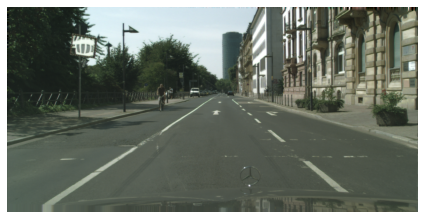

In [306]:
# plot it
plt.imshow(img)
plt.axis('off')
plt.tight_layout()

Coloured label

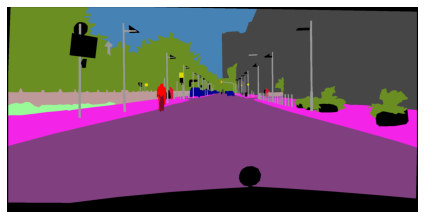

In [307]:
plt.imshow(colour_label)
plt.axis('off')
plt.tight_layout()

Predict using the saved model

In [303]:
pred, shape = model(img)
pred = np.argmax(pred, axis=-1)
colour_pred = cityscapes.COLOUR_PALETTE[pred]

Shape prediction

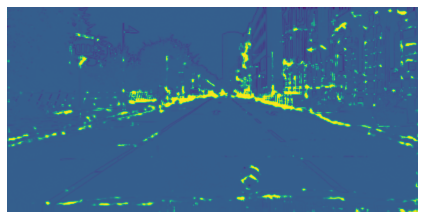

In [308]:
plt.imshow(shape[0, ..., 0])
plt.axis('off')
plt.tight_layout()

Semantic segmentation

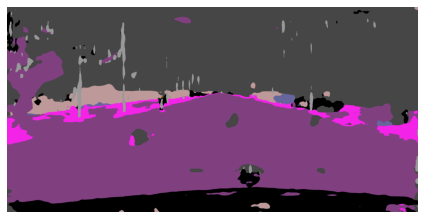

In [309]:
plt.imshow(colour_pred[0])
plt.axis('off')
plt.tight_layout()

# Results analysis with cityscapescripts

#### Save predicted images to a folder

In [310]:
def generate_results():
    lookup_arr = np.zeros([19], dtype=np.uint8)
    for i in range(19):
        lookup_arr[i] = cityscapes.TRAINID_TO_LABEL_ID[i]
    model = gated_shape_cnn.model.model_definition.GSCNNInfer('logs/model/save')
    data = CityScapesRaw('cityscape')
    paths = data.get_img_paths(split=cityscapes.VAL)
    n = len(paths)

    for k, im_p in enumerate(paths):
        if k%10 == 0:
            print('done {} of {}'.format(k, n))
        name = os.path.basename(im_p)
        save_path = os.path.join('cityscape/results', name)
        img = imageio.imread(im_p)
        pred, shape = model(img)
        pred = np.argmax(pred[0], axis=-1)
        pred = lookup_arr[pred].astype(np.uint8)
        imageio.imsave(save_path, pred)

In [311]:
generate_results()

done 0 of 500
done 10 of 500
done 20 of 500
done 30 of 500
done 40 of 500
done 50 of 500
done 60 of 500
done 70 of 500
done 80 of 500
done 90 of 500
done 100 of 500
done 110 of 500
done 120 of 500
done 130 of 500
done 140 of 500
done 150 of 500
done 160 of 500
done 170 of 500
done 180 of 500
done 190 of 500
done 200 of 500
done 210 of 500
done 220 of 500
done 230 of 500
done 240 of 500
done 250 of 500
done 260 of 500
done 270 of 500
done 280 of 500
done 290 of 500
done 300 of 500
done 310 of 500
done 320 of 500
done 330 of 500
done 340 of 500
done 350 of 500
done 360 of 500
done 370 of 500
done 380 of 500
done 390 of 500
done 400 of 500
done 410 of 500
done 420 of 500
done 430 of 500
done 440 of 500
done 450 of 500
done 460 of 500
done 470 of 500
done 480 of 500
done 490 of 500


### Evaluate using cityscapescripts

In [312]:
os.environ['CITYSCAPES_DATASET'] = 'cityscape'
os.environ['CITYSCAPES_RESULTS'] = 'cityscape/results'

#### Confusion matrix, IoU and nIoU for every class by cityscapescripts
nIoU/iIoU that is introduced in the paper\
M. Cordts, M. Omran, S. Ramos, T. Rehfeld, M. Enzweiler, R. Benenson, U. Franke, S. Roth, and B. Schiele, “The Cityscapes Dataset for Semantic Urban Scene Understanding,” in Proc. of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016.\

Only the Confusion matrix is used for analysis in this project.

In [313]:
!python /Users/rajithamuthukrishnan/opt/anaconda3/lib/python3.8/site-packages/cityscapesscripts/evaluation/evalPixelLevelSemanticLabeling.py

Evaluating 500 pairs of images...
Images Processed: 500 

-------------- ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------- 
              |  u   |  e   |  r   |  o   |  s   |  d   |  g   |  r   |  s   |  p   |  r   |  b   |  w   |  f   |  g   |  b   |  t   |  p   |  p   |  t   |  t   |  v   |  t   |  s   |  p   |  r   |  c   |  t   |  b   |  c   |  t   |  t   |  m   |  b   | Prior |
-------------- ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------- 
    unlabeled | 0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.01   0.00   0.00   0.00   0.00   0.00   0.0